In [88]:
from tqdm import tqdm
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [42]:
# Get the data and split into train, validation and test sets
X = np.load('data/X.npy')
X = np.moveaxis(X, 1, 2)
y = np.load('data/y.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

train_dataloader = DataLoader(TensorDataset(X_train_tensors, y_train_tensors),
                              batch_size=64, shuffle=True, num_workers=8) 
test_dataloader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors),
                             batch_size=64, shuffle=True, num_workers=8) 

(11453, 6, 60) (11453, 3)
(2864, 6, 60) (2864, 3)
----
torch.Size([11453, 6, 60]) torch.Size([11453, 3])
torch.Size([2864, 6, 60]) torch.Size([2864, 3])


In [43]:
class LSTM_test(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_test, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [86]:
num_epochs = 300 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = X_train.shape[2] #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 3 

model = LSTM_test(num_classes, input_size, hidden_size, num_layers) 

criterion = torch.nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [83]:
def history_logger(history, data):
    for idx, key in enumerate(history):
        history[key].append(data[idx])

In [87]:
history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for epoch in range(num_epochs):
    loss_total = 0
    val_loss_total = 0
    correct_total = 0
    val_correct_total = 0
    
    model.train()
    for batch_idx, samples in enumerate(train_dataloader):
        outputs = model.forward(samples[0]) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
        # obtain the loss function
        loss = criterion(outputs, samples[1])
        loss.backward() #calculates the loss of the loss function
        optimizer.step() #improve from loss, i.e backprop
        
        loss_total += loss.item()
        correct_total += (samples[1].argmax(axis=1) == outputs.argmax(axis=1)).float().sum().item()
    
    model.eval()
    with torch.no_grad():
        for batch_idx_test, samples in enumerate(test_dataloader):
            outputs = model.forward(samples[0]) #forward pass
            loss = criterion(outputs, samples[1])

            val_loss_total += loss.item()
            val_correct_total += (samples[1].argmax(axis=1) == outputs.argmax(axis=1)).float().sum().item() 
    
    _loss = loss_total / (batch_idx+1)
    _acc = correct_total / X_train.shape[0]
    _val_loss = val_loss_total / (batch_idx_test+1)
    _val_acc = val_correct_total / X_test.shape[0]
    
    history_logger(history, [_loss,  _val_loss, _acc, _val_acc])
    
    print("Epoch: %d, loss: %1.5f, accuracy: %1.5f, val_loss: %1.5f, val_accuracy: %1.5f" % \
          (epoch, _loss, _acc, _val_loss, _val_acc)) 

Epoch: 0, loss: 1.02161, accuracy: 0.50371, val_loss: 1.01133, val_accuracy: 0.50803
Epoch: 1, loss: 1.02004, accuracy: 0.50406, val_loss: 1.01002, val_accuracy: 0.50803
Epoch: 2, loss: 1.01905, accuracy: 0.50406, val_loss: 1.01257, val_accuracy: 0.50803
Epoch: 3, loss: 1.01836, accuracy: 0.50406, val_loss: 1.01345, val_accuracy: 0.50803
Epoch: 4, loss: 1.01480, accuracy: 0.50397, val_loss: 0.99663, val_accuracy: 0.50803
Epoch: 5, loss: 0.98966, accuracy: 0.51716, val_loss: 0.98157, val_accuracy: 0.53142
Epoch: 6, loss: 0.97515, accuracy: 0.52667, val_loss: 0.96756, val_accuracy: 0.52793
Epoch: 7, loss: 0.96881, accuracy: 0.53017, val_loss: 0.96502, val_accuracy: 0.53596
Epoch: 8, loss: 0.96394, accuracy: 0.53174, val_loss: 0.96212, val_accuracy: 0.53736
Epoch: 9, loss: 0.96381, accuracy: 0.53121, val_loss: 0.96498, val_accuracy: 0.53352
Epoch: 10, loss: 0.96493, accuracy: 0.53217, val_loss: 0.97734, val_accuracy: 0.53492
Epoch: 11, loss: 0.96278, accuracy: 0.53672, val_loss: 0.96858, 

Epoch: 96, loss: 0.85403, accuracy: 0.59853, val_loss: 0.95563, val_accuracy: 0.56041
Epoch: 97, loss: 0.85513, accuracy: 0.59443, val_loss: 0.94992, val_accuracy: 0.55866
Epoch: 98, loss: 0.85411, accuracy: 0.59626, val_loss: 0.96567, val_accuracy: 0.55552
Epoch: 99, loss: 0.85005, accuracy: 0.59932, val_loss: 0.94694, val_accuracy: 0.55901
Epoch: 100, loss: 0.84606, accuracy: 0.60237, val_loss: 0.96695, val_accuracy: 0.55203
Epoch: 101, loss: 0.85096, accuracy: 0.59670, val_loss: 0.96806, val_accuracy: 0.55342
Epoch: 102, loss: 0.84773, accuracy: 0.60002, val_loss: 0.96151, val_accuracy: 0.55412
Epoch: 103, loss: 0.84810, accuracy: 0.60220, val_loss: 0.95357, val_accuracy: 0.56634
Epoch: 104, loss: 0.85403, accuracy: 0.59783, val_loss: 0.95600, val_accuracy: 0.55377
Epoch: 105, loss: 0.85229, accuracy: 0.59923, val_loss: 0.95815, val_accuracy: 0.55517
Epoch: 106, loss: 0.84758, accuracy: 0.59906, val_loss: 0.95325, val_accuracy: 0.55342
Epoch: 107, loss: 0.84692, accuracy: 0.60010, v

Epoch: 191, loss: 0.74805, accuracy: 0.65773, val_loss: 1.06995, val_accuracy: 0.53911
Epoch: 192, loss: 0.73828, accuracy: 0.66463, val_loss: 1.08401, val_accuracy: 0.55482
Epoch: 193, loss: 0.73985, accuracy: 0.66175, val_loss: 1.07050, val_accuracy: 0.53527
Epoch: 194, loss: 0.73884, accuracy: 0.66384, val_loss: 1.06170, val_accuracy: 0.54295
Epoch: 195, loss: 0.74125, accuracy: 0.66131, val_loss: 1.07071, val_accuracy: 0.53946
Epoch: 196, loss: 0.73610, accuracy: 0.65974, val_loss: 1.10123, val_accuracy: 0.55063
Epoch: 197, loss: 0.73401, accuracy: 0.66315, val_loss: 1.06825, val_accuracy: 0.55517
Epoch: 198, loss: 0.72886, accuracy: 0.66603, val_loss: 1.07835, val_accuracy: 0.54539
Epoch: 199, loss: 0.73928, accuracy: 0.65860, val_loss: 1.09201, val_accuracy: 0.53980
Epoch: 200, loss: 0.73507, accuracy: 0.66009, val_loss: 1.10998, val_accuracy: 0.52025
Epoch: 201, loss: 0.74051, accuracy: 0.66376, val_loss: 1.09837, val_accuracy: 0.53806
Epoch: 202, loss: 0.73269, accuracy: 0.6648

Epoch: 286, loss: 0.66068, accuracy: 0.70890, val_loss: 1.18571, val_accuracy: 0.53352
Epoch: 287, loss: 0.65857, accuracy: 0.70855, val_loss: 1.22653, val_accuracy: 0.53561
Epoch: 288, loss: 0.65958, accuracy: 0.70558, val_loss: 1.19295, val_accuracy: 0.53596
Epoch: 289, loss: 0.64972, accuracy: 0.71352, val_loss: 1.21528, val_accuracy: 0.53596
Epoch: 290, loss: 0.65371, accuracy: 0.71160, val_loss: 1.22689, val_accuracy: 0.53806
Epoch: 291, loss: 0.65261, accuracy: 0.71422, val_loss: 1.22209, val_accuracy: 0.53736
Epoch: 292, loss: 0.64832, accuracy: 0.71335, val_loss: 1.22842, val_accuracy: 0.53736
Epoch: 293, loss: 0.65646, accuracy: 0.70637, val_loss: 1.25066, val_accuracy: 0.53422
Epoch: 294, loss: 0.65829, accuracy: 0.70829, val_loss: 1.20272, val_accuracy: 0.53876
Epoch: 295, loss: 0.67642, accuracy: 0.69571, val_loss: 1.22014, val_accuracy: 0.53980
Epoch: 296, loss: 0.66926, accuracy: 0.69580, val_loss: 1.21092, val_accuracy: 0.53841
Epoch: 297, loss: 0.67775, accuracy: 0.6996

In [94]:
history['val_loss']

[0.5037108181262552,
 0.5040600715969615,
 0.5040600715969615,
 0.5040600715969615,
 0.5039727582292849,
 0.5171570767484502,
 0.5266742338251986,
 0.5301667685322623,
 0.5317384091504409,
 0.5312145289443814,
 0.5321749759888239,
 0.5367152711080067,
 0.5343578101807387,
 0.5362787042696237,
 0.5381122849908321,
 0.5384615384615384,
 0.5400331790797172,
 0.5425652667423383,
 0.5412555662271894,
 0.5433510870514275,
 0.545184667772636,
 0.551383916877674,
 0.5457085479786955,
 0.5545271981140313,
 0.5498995896271719,
 0.5549637649524142,
 0.5543525713786781,
 0.5562734654675631,
 0.5553130184231205,
 0.5587182397625077,
 0.5526936173928229,
 0.5503361564655549,
 0.5519077970837335,
 0.5565354055705929,
 0.557146599144329,
 0.5555749585261504,
 0.5560115253645334,
 0.5581070461887715,
 0.5606391338513926,
 0.5634331616170436,
 0.5644809220291627,
 0.5595040600715969,
 0.564393608661486,
 0.5608137605867458,
 0.563345848249367,
 0.5615122675281585,
 0.5615122675281585,
 0.567187636427137

C:\Users\oorakci\AppData\Local\Temp/ipykernel_14628/3097220172.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


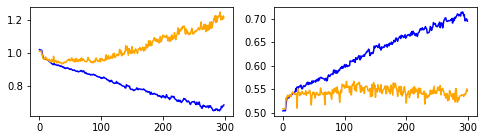

In [95]:
fig, ax = plt.subplots(ncols=2, figsize=(8,2))
ax[0].plot(history['loss'], c='blue')
ax[0].plot(history['acc'], c='orange')
ax[1].plot(history['val_loss'], c='blue')
ax[1].plot(history['val_acc'], c='orange')

fig.show()